
<p><img align="left" src="https://www.cqf.com/themes/custom/creode/logo.svg" style="vertical-align: top; padding-top: 23px;" width="10%"/>
<img align="right" src="https://upload.wikimedia.org/wikipedia/commons/c/c3/Python-logo-notext.svg" style="vertical-align: middle;" width="12%"/>
<font color="#306998"><h1><center>Python Labs</center></h1></font></p>
<p></p><h1><center>Binomial Trees</center></h1>
<center><b>Kannan Singaravelu</b></center>
<center>kannan.singaravelu@fitchlearning.com</center>



<h2 id="Binomial-Tree">Binomial Tree<a class="anchor-link" href="#Binomial-Tree">¶</a></h2><p>The binomial tree method was pioneered by Cox, Ross, and Robinstein in 1979. The binomial model allows the stock to move up or down a specific amount over the next time step. Given the initial stock price <code>S</code>, we allow it to either go up or down by a factor <code>u</code> and <code>v</code> resulting in the value $uS$ and $vS$ after the next time step.</p>
<p>Extending this random walk after two time steps, the asset will either be at $u^2S$, if there are two up moves or at $v^2S$ if there are two down moves or at $uvS$ if an up was followed by a down move or vice versa. We can extend this to any number of time step (or branches) depending on how complex you want the model to be or until expiration.</p>
<p>This structure where nodes represent the values taken by the asset is called the <strong>binomial tree</strong>.</p>



<h3 id="Import-Libraries">Import Libraries<a class="anchor-link" href="#Import-Libraries">¶</a></h3><p>We'll import the required libraries that we'll use in this example.</p>


In [ ]:
import os
import sys
# ROOT_DIR = os.path.abspath('')
sys.path.append('C:\\Users\\Administrator\\cqf python lab\\M2\\for teach') #添加搜索环境

In [1]:

# Import math functions from NumPy
from numpy import *

# Import plotting functions from helper 
from helper import plot_asset_path, plot_probability, plot_binomial_tree




<h3 id="Price-Path">Price Path<a class="anchor-link" href="#Price-Path">¶</a></h3><p>The probability of reaching a particular node in the binomial tree depends on the numbers of distinct paths to that node and the probabilities of the up and down moves. The following figures shows the number of paths to each node and the probability of reaching to that node.</p>


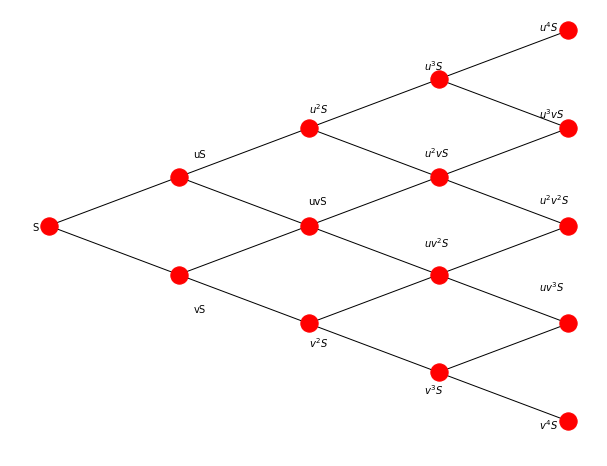

In [2]:

# Plot asset price path
plot_asset_path()




<h3 id="Path-Probability">Path Probability<a class="anchor-link" href="#Path-Probability">¶</a></h3>


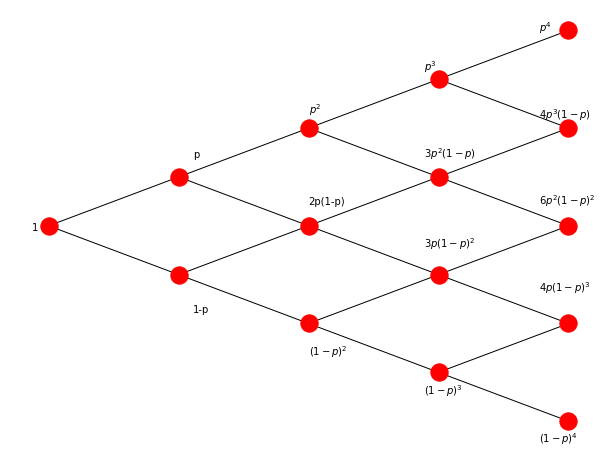

In [3]:

# Plot node probability
plot_probability()




<h3 id="Risk-Neutral-Probability">Risk Neutral Probability<a class="anchor-link" href="#Risk-Neutral-Probability">¶</a></h3><p>Risk-neutral measure is a probability measure such that each share price today is the discounted expectations of the share price. From Paul's lecture, we know the formula for $u$, $v$, $p\space'$ and $V$ are as follows,</p>
<p>$ u = 1+ {\sigma\sqrt{\delta t}} $</p>
<p>$ v = 1- {\sigma\sqrt{\delta t}} $</p>
<p>The underlying instrument will move up or down by a specific factor $u$ or $v$ per step of the tree where $u$ $\geq$ 1 and 0 $&lt;$ $v$ $\leq$ 1.</p>
<p>$ p\space' = \frac{1}{2} + \frac{r \sqrt\delta t}{2\sigma} $</p>
<p>where, $p\space'$ the risk-neutral probability.</p>
<p>$ V = \frac{1}{1+r\delta t}\space (p\space' V^{+} + (1-p\space')V^{-}) $</p>
<p>where, $V$ is the option value which is present value of some expectation : sum probabilities multiplied by events.</p>



<h2 id="Building-Binomial-Tree">Building Binomial Tree<a class="anchor-link" href="#Building-Binomial-Tree">¶</a></h2><p>Next, we will build a binomial tree using the risk neutral probability. Building a tree is a multi step process which involves.</p>
<p><strong>Step 1</strong>: Draw a n-step tree</p>
<p><strong>Step 2</strong>: At the end of n-step, estimate terminal prices</p>
<p><strong>Step 3</strong>: Calculate the option value at each node based on the terminal price, exercise price and type</p>
<p><strong>Step 4</strong>: Discount it back one step, that is, from n to n-1, according to the risk neutral probability</p>
<p><strong>Step 5</strong>: Repeat the previous step until we find the final value at step 0</p>



<h3 id="Binomial-Pricing-Model">Binomial Pricing Model<a class="anchor-link" href="#Binomial-Pricing-Model">¶</a></h3><p>Let's now define a binomial option pricing function</p>


In [4]:

zeros((4+1, 4+1))



array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [5]:

def binomial_option(spot, strike, rate, sigma, time, steps, output=0):
    
    """
    binomial_option(spot, strike, rate, sigma, time, steps, output=0)
    
    Function for building binomial option tree for european call option payoff. 
    
    Parameters
    ----------
    spot        int or float   - spot price
    strike      int or float   - strike price 
    rate        float          - interest rate
    sigma       float          - volatility
    time        int or float   - expiration time
    steps       int            - number of time steps
    output      int            - [0: price, 1: payoff, 2: option value, 3: option delta]
    
    Returns
    ----------
    out : ndarray
    An array object of price, payoff, option value and delta as specified by the output parameter

    """
    
    # define parameters
    ts = time/steps                              # ts is time steps, dt
    u = 1 + sigma*sqrt(ts)                       # u is up factor
    v = 1 - sigma*sqrt(ts)                       # v is down factor
    p = 0.5 + rate*sqrt(ts)/(2*sigma)            # p here is risk neutral probability (p') - for ease of use
    df = 1/(1+rate*ts)                           # df is discount factor

    # initialize arrays
    px = zeros((steps+1, steps+1)) # price path
    cp = zeros((steps+1, steps+1)) # call intrinsic payoff
    V = zeros((steps+1, steps+1))  # option value
    d = zeros((steps+1, steps+1))  # delta value
    
    # binomial loop
    for j in range(steps+1):
        for i in range(j+1):
            px[i,j] = spot * power(v,i) * power(u,j-i)
            cp[i,j] = maximum(px[i,j] - strike,0)
            
    for j in range(steps+1, 0, -1):
        for i in range(j):
            if (j == steps+1):
                V[i,j-1] = cp[i,j-1]    # terminal payoff
                d[i,j-1] = 0            # terminal delta
            else:
                V[i,j-1] = df*(p*V[i,j]+(1-p)*V[i+1,j])
                d[i,j-1] = (V[i,j]-V[i+1,j])/(px[i,j]-px[i+1,j])
                    
    results = around(px,2), around(cp,2), around(V,2), around(d,4)
    
    return results[output]



In [6]:

# Asset price
px = binomial_option(100,100,0.05,0.2,1,4,0)
px



array([[100.  , 110.  , 121.  , 133.1 , 146.41],
       [  0.  ,  90.  ,  99.  , 108.9 , 119.79],
       [  0.  ,   0.  ,  81.  ,  89.1 ,  98.01],
       [  0.  ,   0.  ,   0.  ,  72.9 ,  80.19],
       [  0.  ,   0.  ,   0.  ,   0.  ,  65.61]])

In [7]:

# Intrinsic value of call options
cp=binomial_option(100,100,0.05,0.2,1,4,1)
cp



array([[ 0.  , 10.  , 21.  , 33.1 , 46.41],
       [ 0.  ,  0.  ,  0.  ,  8.9 , 19.79],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

In [8]:

# Option price 
opx=binomial_option(100,100,0.05,0.2,1,4,2)
opx



array([[10.29, 15.88, 23.83, 34.33, 46.41],
       [ 0.  ,  3.39,  6.11, 10.99, 19.79],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

In [9]:

# Option delta
delta=binomial_option(100,100,0.05,0.2,1,4,3)
delta



array([[0.6241, 0.8053, 0.9645, 1.    , 0.    ],
       [0.    , 0.3393, 0.5553, 0.9086, 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ]])

In [10]:

# Binomial Option Price
print(f"European Call Option Price using Binomial Tree Method: {opx[0,0]:.2f}")



European Call Option Price using Binomial Tree Method: 10.29



<h3 id="Visualize-the-Binomial-Tree">Visualize the Binomial Tree<a class="anchor-link" href="#Visualize-the-Binomial-Tree">¶</a></h3>


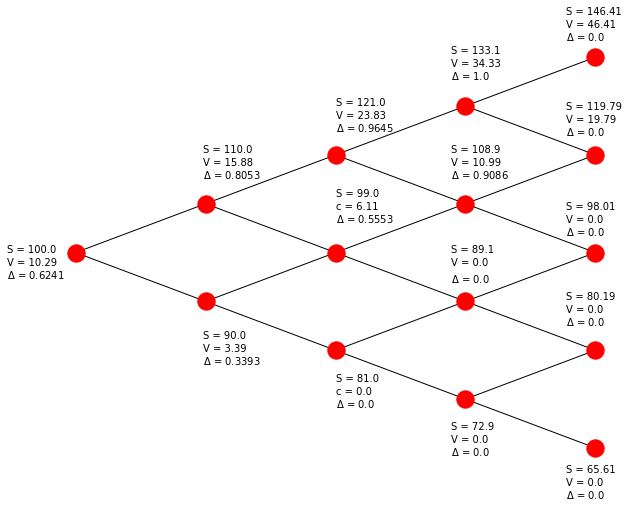

In [11]:

# Plot a 4-Step Binomial Tree 
plot_binomial_tree(px[0,0], px, opx, delta)




<h2 id="References">References<a class="anchor-link" href="#References">¶</a></h2><ul>
<li><p>Numpy documentation <a href="https://docs.scipy.org/doc/numpy/">https://docs.scipy.org/doc/numpy/</a></p>
</li>
<li><p>Paul Wilmott (2007), Paul Wilmott introduces Quantitative Finance</p>
</li>
</ul>
